In [ ]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
from os import listdir
import cv2
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

In [ ]:
print("The number of images with facemask labelled 'with':",len(os.listdir('/content/drive/MyDrive/deeplearningproject/Data/with_mask')))
print("The number of images with facemask labelled 'without':",len(os.listdir('/content/drive/MyDrive/deeplearningproject/Data/without_mask')))

The number of images with facemask labelled 'with': 3725
The number of images with facemask labelled 'without': 3828


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    dataset = []
    
    for unitData in os.listdir(SOURCE):
        data = SOURCE + unitData
        if(os.path.getsize(data) > 0):
            dataset.append(unitData)
        else:
            print('Skipped ' + unitData)
            print('Invalid file i.e zero size')
    
    train_set_length = int(len(dataset) * SPLIT_SIZE)
    test_set_length = int(len(dataset) - train_set_length)
    shuffled_set = random.sample(dataset, len(dataset))
    train_set = dataset[0:train_set_length]
    test_set = dataset[-test_set_length:]
       
    for unitData in train_set:
        temp_train_set = SOURCE + unitData
        final_train_set = TRAINING + unitData
        copyfile(temp_train_set, final_train_set)
    
    for unitData in test_set:
        temp_test_set = SOURCE + unitData
        final_test_set = TESTING + unitData
        copyfile(temp_test_set, final_test_set)
        
# veri with ve without klasörleri ile test ve train olarak ayrılır     
YES_SOURCE_DIR = "/content/drive/MyDrive/deeplearningproject/Data/with_mask/"
TRAINING_YES_DIR = "/content/drive/MyDrive/deeplearningproject/Data/training/with/"
TESTING_YES_DIR = "/content/drive/MyDrive/deeplearningproject/Data/testing/with/"
NO_SOURCE_DIR = "/content/drive/MyDrive/deeplearningproject/Data/without_mask/"
TRAINING_NO_DIR = "/content/drive/MyDrive/deeplearningproject/Data/training/without/"
TESTING_NO_DIR = "/content/drive/MyDrive/deeplearningproject/Data/testing/without/"
# veriler %80 eğitim verisi %20 test verisi olarak ayrılır
split_size = .8
split_data(YES_SOURCE_DIR, TRAINING_YES_DIR, TESTING_YES_DIR, split_size)
split_data(NO_SOURCE_DIR, TRAINING_NO_DIR, TESTING_NO_DIR, split_size)

In [ ]:
print("The number of images with facemask in the training set labelled 'with':", len(os.listdir('/content/drive/MyDrive/deeplearningproject/Data/training/with/')))
print("The number of images with facemask in the test set labelled 'with':", len(os.listdir('/content/drive/MyDrive/deeplearningproject/Data/testing/with/')))
print("The number of images without facemask in the training set labelled 'without':", len(os.listdir('/content/drive/MyDrive/deeplearningproject/Data/training/without/')))
print("The number of images without facemask in the test set labelled 'without':", len(os.listdir('/content/drive/MyDrive/deeplearningproject/Data/without/')))

The number of images with facemask in the training set labelled 'with': 2980
The number of images with facemask in the test set labelled 'with': 745
The number of images without facemask in the training set labelled 'without': 3062
The number of images without facemask in the test set labelled 'without': 766


In [ ]:
TRAINING_DIR = "/content/drive/MyDrive/deeplearningproject/Data/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=10, 
                                                    target_size=(150, 150))
VALIDATION_DIR = "/content/drive/MyDrive/deeplearningproject/Data/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                         batch_size=10, 
                                                         target_size=(150, 150))
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

Found 6042 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.


In [ ]:
# 100 tane 3x3 lük filtre kullanılır
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(100, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(100, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit_generator(train_generator,
                              epochs=30,
                              validation_data=validation_generator,
                              callbacks=[checkpoint])

Epoch 1/30
 99/605 [===>..........................] - ETA: 4:31 - loss: 1.1127 - accuracy: 0.6298

D:\Program\Anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


605/605 [==============================] - 358s 591ms/step - loss: 0.6469 - accuracy: 0.7286 - val_loss: 0.3571 - val_accuracy: 0.8590
INFO:tensorflow:Assets written to: model-001.model\assets
Epoch 2/30
236/605 [==========>...................] - ETA: 3:16 - loss: 0.4272 - accuracy: 0.8000

D:\Program\Anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


605/605 [==============================] - 345s 570ms/step - loss: 0.4300 - accuracy: 0.8008 - val_loss: 0.3086 - val_accuracy: 0.8776
INFO:tensorflow:Assets written to: model-002.model\assets
Epoch 3/30
186/605 [========>.....................] - ETA: 3:33 - loss: 0.4420 - accuracy: 0.7987

D:\Program\Anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


605/605 [==============================] - 323s 533ms/step - loss: 0.4272 - accuracy: 0.8075 - val_loss: 0.3074 - val_accuracy: 0.8789
INFO:tensorflow:Assets written to: model-003.model\assets
Epoch 4/30
351/605 [================>.............] - ETA: 1:54 - loss: 0.4089 - accuracy: 0.8251

D:\Program\Anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


605/605 [==============================] - 289s 477ms/step - loss: 0.4087 - accuracy: 0.8229 - val_loss: 0.2875 - val_accuracy: 0.8663
INFO:tensorflow:Assets written to: model-004.model\assets
Epoch 5/30
 73/605 [==>...........................] - ETA: 3:56 - loss: 0.3827 - accuracy: 0.8250

D:\Program\Anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


605/605 [==============================] - 288s 476ms/step - loss: 0.3862 - accuracy: 0.8288 - val_loss: 0.2777 - val_accuracy: 0.8769
INFO:tensorflow:Assets written to: model-005.model\assets
Epoch 6/30
489/605 [=======================>......] - ETA: 51s - loss: 0.3972 - accuracy: 0.8251

D:\Program\Anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


605/605 [==============================] - 286s 473ms/step - loss: 0.3936 - accuracy: 0.8275 - val_loss: 0.2301 - val_accuracy: 0.9153
INFO:tensorflow:Assets written to: model-006.model\assets
Epoch 7/30
380/605 [=================>............] - ETA: 1:47 - loss: 0.3681 - accuracy: 0.8407

D:\Program\Anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


605/605 [==============================] - 306s 506ms/step - loss: 0.3679 - accuracy: 0.8394 - val_loss: 0.2072 - val_accuracy: 0.9146
INFO:tensorflow:Assets written to: model-007.model\assets
Epoch 8/30
 94/605 [===>..........................] - ETA: 3:47 - loss: 0.3564 - accuracy: 0.8397

D:\Program\Anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


605/605 [==============================] - 291s 480ms/step - loss: 0.3600 - accuracy: 0.8416 - val_loss: 0.1922 - val_accuracy: 0.9272
INFO:tensorflow:Assets written to: model-008.model\assets
Epoch 9/30
259/605 [===========>..................] - ETA: 2:40 - loss: 0.3561 - accuracy: 0.8342

D:\Program\Anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


605/605 [==============================] - 301s 497ms/step - loss: 0.3473 - accuracy: 0.8446 - val_loss: 0.2073 - val_accuracy: 0.9252
Epoch 10/30
605/605 [==============================] - 297s 491ms/step - loss: 0.3460 - accuracy: 0.8508 - val_loss: 0.1944 - val_accuracy: 0.9259
Epoch 11/30
605/605 [==============================] - 287s 474ms/step - loss: 0.3306 - accuracy: 0.8611 - val_loss: 0.2046 - val_accuracy: 0.9252
Epoch 12/30
605/605 [==============================] - 286s 473ms/step - loss: 0.3252 - accuracy: 0.8534 - val_loss: 0.1813 - val_accuracy: 0.9312
INFO:tensorflow:Assets written to: model-012.model\assets
Epoch 13/30
 19/605 [..............................] - ETA: 4:22 - loss: 0.2589 - accuracy: 0.9123

D:\Program\Anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


605/605 [==============================] - 285s 471ms/step - loss: 0.3030 - accuracy: 0.8762 - val_loss: 0.1906 - val_accuracy: 0.9325
Epoch 14/30
605/605 [==============================] - 285s 471ms/step - loss: 0.3112 - accuracy: 0.8673 - val_loss: 0.1811 - val_accuracy: 0.9272
INFO:tensorflow:Assets written to: model-014.model\assets
Epoch 15/30
140/605 [=====>........................] - ETA: 3:24 - loss: 0.2640 - accuracy: 0.8857

D:\Program\Anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


605/605 [==============================] - 284s 470ms/step - loss: 0.2814 - accuracy: 0.8769 - val_loss: 0.1738 - val_accuracy: 0.9305
INFO:tensorflow:Assets written to: model-015.model\assets
Epoch 16/30
403/605 [==================>...........] - ETA: 1:30 - loss: 0.2678 - accuracy: 0.8866

D:\Program\Anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


605/605 [==============================] - 287s 474ms/step - loss: 0.2721 - accuracy: 0.8838 - val_loss: 0.1669 - val_accuracy: 0.9345
INFO:tensorflow:Assets written to: model-016.model\assets
Epoch 17/30
458/605 [=====================>........] - ETA: 1:05 - loss: 0.2561 - accuracy: 0.8971

D:\Program\Anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


605/605 [==============================] - 285s 471ms/step - loss: 0.2608 - accuracy: 0.8940 - val_loss: 0.1562 - val_accuracy: 0.9424
INFO:tensorflow:Assets written to: model-017.model\assets
Epoch 18/30
 46/605 [=>............................] - ETA: 4:08 - loss: 0.2388 - accuracy: 0.9110

D:\Program\Anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


605/605 [==============================] - 286s 472ms/step - loss: 0.2578 - accuracy: 0.8937 - val_loss: 0.1624 - val_accuracy: 0.9385
Epoch 19/30
605/605 [==============================] - 286s 472ms/step - loss: 0.2647 - accuracy: 0.8952 - val_loss: 0.1515 - val_accuracy: 0.9497
INFO:tensorflow:Assets written to: model-019.model\assets
Epoch 20/30
276/605 [============>.................] - ETA: 2:26 - loss: 0.2609 - accuracy: 0.8938

D:\Program\Anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


605/605 [==============================] - 285s 472ms/step - loss: 0.2621 - accuracy: 0.8937 - val_loss: 0.1617 - val_accuracy: 0.9404
Epoch 21/30
605/605 [==============================] - 287s 474ms/step - loss: 0.2562 - accuracy: 0.9059 - val_loss: 0.1692 - val_accuracy: 0.9424
Epoch 22/30
605/605 [==============================] - 286s 473ms/step - loss: 0.2409 - accuracy: 0.9057 - val_loss: 0.1472 - val_accuracy: 0.9457
INFO:tensorflow:Assets written to: model-022.model\assets
Epoch 23/30
169/605 [=======>......................] - ETA: 3:14 - loss: 0.2448 - accuracy: 0.9006

D:\Program\Anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


605/605 [==============================] - 286s 472ms/step - loss: 0.2470 - accuracy: 0.9000 - val_loss: 0.1394 - val_accuracy: 0.9537
INFO:tensorflow:Assets written to: model-023.model\assets
Epoch 24/30
214/605 [=========>....................] - ETA: 2:54 - loss: 0.2246 - accuracy: 0.9110

D:\Program\Anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


605/605 [==============================] - 290s 480ms/step - loss: 0.2301 - accuracy: 0.9059 - val_loss: 0.1677 - val_accuracy: 0.9391
Epoch 25/30
605/605 [==============================] - 294s 485ms/step - loss: 0.2244 - accuracy: 0.9099 - val_loss: 0.1363 - val_accuracy: 0.9497
INFO:tensorflow:Assets written to: model-025.model\assets
Epoch 26/30
291/605 [=============>................] - ETA: 2:19 - loss: 0.2369 - accuracy: 0.9040

D:\Program\Anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


605/605 [==============================] - 284s 469ms/step - loss: 0.2382 - accuracy: 0.9047 - val_loss: 0.1411 - val_accuracy: 0.9477
Epoch 27/30
605/605 [==============================] - 284s 470ms/step - loss: 0.2358 - accuracy: 0.9051 - val_loss: 0.1371 - val_accuracy: 0.9477
Epoch 28/30
605/605 [==============================] - 285s 471ms/step - loss: 0.2185 - accuracy: 0.9170 - val_loss: 0.1201 - val_accuracy: 0.9550
INFO:tensorflow:Assets written to: model-028.model\assets
Epoch 29/30
191/605 [========>.....................] - ETA: 3:02 - loss: 0.2069 - accuracy: 0.9163

D:\Program\Anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


605/605 [==============================] - 284s 469ms/step - loss: 0.2157 - accuracy: 0.9147 - val_loss: 0.1314 - val_accuracy: 0.9550
Epoch 30/30
605/605 [==============================] - 287s 475ms/step - loss: 0.2038 - accuracy: 0.9219 - val_loss: 0.2359 - val_accuracy: 0.9140


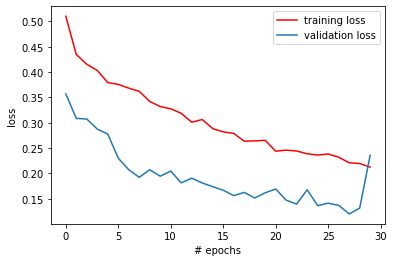

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

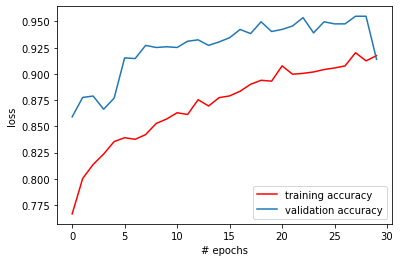

In [ ]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
model.save_weights('/content/drive/MyDrive/deeplearningproject/CNN/CNN_Model.h5')

In [ ]:
from keras.models import load_model
model.load_weights('/content/drive/MyDrive/deeplearningproject/CNN/CNN_Model.h5')

In [ ]:
face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')